## Read in the Data

First I imported and installed all the libraries required to extract important features of the data

In [1]:
# import libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plp
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
from numba import cuda

In [4]:
!pip install squarify
import matplotlib.pyplot as plt
import squarify #

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/bin/python -m pip install --upgrade pip' command.


Then I read the data, the data has twitter texts of different people around Colombia and the level of income of them. The idea with this project is creating a model that based on the text and the words that people use in ther tweets being able to classify an user in "high income" or "low income" user.

In [2]:
csv_file = 'Data/tweets_bogota_udacity_f.csv'
twitter_df = pd.read_csv(csv_file, sep=';', encoding='utf-16')

# print out the first few rows of data info
twitter_df.head()

Texto    ciudad  \
0                     @solcaffarena3 😂😂😂 es verdad 🤣  Medellín   
1  Volar cual cohete, atacar como bólido. en Anti...  Medellín   
2  Liberación de sabaleta del compañero Carlos\n\...  Medellín   
3  Vamos empezando a dejarlo todo @industryclubme...  Medellín   
4  Pesca de sabaleta del compañero Carlos\n\n#esp...  Medellín   

        fecha_creacion  identificacion_tweet ingresos              usuario  \
0  2020-10-11 19:52:40   1315379811175497729    Altos  1269105923265564682   
1  2020-10-11 19:39:51   1315376588138205185    Altos   809919552020684800   
2  2020-10-11 17:49:19   1315348769387446272    Altos            801608203   
3  2020-10-11 17:45:58   1315347925598457862    Altos            304266436   
4  2020-10-11 17:38:26   1315346030104326144    Altos            801608203   

      zona  
0  Poblado  
1  Poblado  
2  Poblado  
3  Poblado  
4  Poblado

# Feature Engineering

The first feature that I am going to obtain is the spelling of the tweet. In order to know if it has a good spelling or a bad spelling. To achieve this it's necessary to download a spanish dictionary and create functions that check the spelling of the full text.

In [3]:
import re
from collections import Counter
path_dictionary='Data/palabras_todas.txt'

def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open(path_dictionary, encoding='utf-8').read()))


def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    letters    = 'ABCDEFGHIJKLMNÑOPQRSTUVWXYZ'
    a=list(set(w for w in words if w in WORDS or w[:1] in letters))
    b=list(set(w for w in words if w[:-1] in WORDS))
    c=list(set(w for w in words if w[:-1]+'o' in WORDS))
    return set(a+b+c)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnñopqrstuvwxyzáéíóú'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [4]:
def iscorrect(sentence2):
    words2=re.findall(r'\w+', sentence2)
    correct=True
    letters    = 'ABCDEFGHIJKLMNÑOPQRSTUVWXYZ'
    for word in words2:
        if (correction(word.lower())!= word.lower()) and (word[:1] not in letters) :
            correct=False
            break
    return correct

Here I proved the method that checked the spelling of a word

In [8]:
#Test the function
iscorrect('Hola, como estás')

True

Second in order of transform the text to data, is necessary to find a spanish stemmer,  in this case I used the Snowball Stemmer.

In [9]:
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
spanish_stemmer = SnowballStemmer('spanish')

#Test Stemmer
print(spanish_stemmer.stem("jugamos"))

jug


In [10]:
#Ejemplo de uso de Stemmization
sent = "Han sido 6 años de amor y lo que nos faltan... Me haces muy feliz y ahora más construyendo nuestro hogar"
ortografia=iscorrect(sent)
sent=re.findall(r'\w+', sent.lower())
diccio_espanol=stopwords.words('spanish')
total=[word for word in sent if word not in diccio_espanol]
spanish_stemmer = SnowballStemmer('spanish')
total=[spanish_stemmer.stem(word) for word in total]

Here I proved that the stemmer was working correctly

In [11]:
total

['sid', '6', 'años', 'amor', 'falt', 'hac', 'feliz', 'ahor', 'constru', 'hog']

I order of visualizing the information I created two word cloud pictures, one for high ibcome people and the other for low income people to check if apparently there was a difference between the terms of both groups.

In [12]:
!pip install wordcloud
import numpy as np
from PIL import Image
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud

     |████████████████████████████████| 365 kB 2.7 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [13]:
from nltk.corpus import stopwords
comment_words = '' 
stopwords =set(stopwords.words('spanish')+['https', 'colombia', 'bogotá', 'cartagena', 'medellín',
                                          'barranquilla', 'cali', 'antioquia', 'co', 'just', 'posted',
                                          'medellin','bogota', 'si', 'así', 'dio'])

comment_words_baj=''
comment_words=''
# iterate through the csv file 
for i, row in twitter_df.iterrows(): 
    val=row['Texto']
    ing=row['ingresos']
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
        
    if ing=='Altos':
        comment_words += " ".join(tokens)+" "
    else:
        comment_words_baj += " ".join(tokens)+" " 

In [14]:
wordcloud_alt = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10,  collocations=False).generate(comment_words) 
wordcloud_baj = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10,  collocations=False).generate(comment_words_baj)

Here I plot the most common words in hig income people

In [15]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_alt) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Here I plot the most common words for low income people

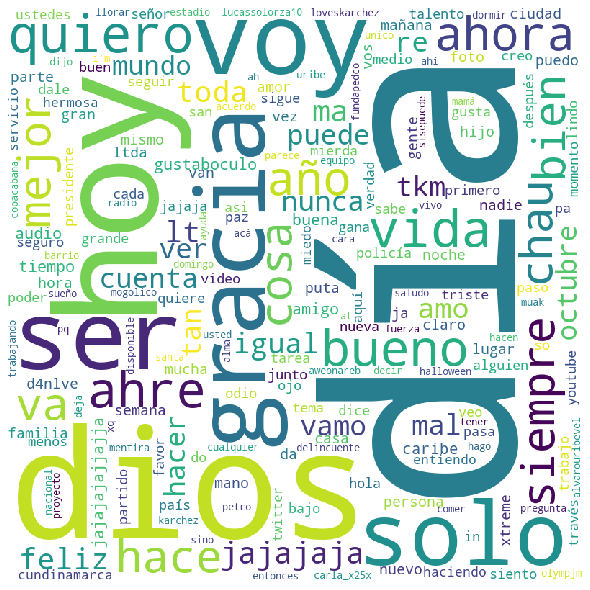

In [16]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_baj) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Another variable that can be of iterest is the sentimen analysis of the text, in order to prove that hypothesis I downloaded a pip package that predicts the sentiment of a sentence in spanish.

In [17]:
!pip install sentiment_analysis_spanish

from sentiment_analysis_spanish import sentiment_analysis
sentiment = sentiment_analysis.SentimentAnalysisSpanish()

     |████████████████████████████████| 15.1 MB 3.1 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/bin/python -m pip install --upgrade pip' command.


Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Here I prove the functionality of the package

In [18]:
print(sentiment.sentiment("no me gusta la tombola es horrible"))


0.00010415492


Other variable that can be of interes was the emojis that people uses in their tweets, so based in this I deciden to create a variable of sentiment based on emojis.

To achieve that, I folowed these steps:

1. Extract the emojis form the text.
2. Transform each emoji to their corresponf¿ding word or sentence in english
3. Use sentiment analysis in english in order to assign a probability to each sentence

In [31]:
!pip install emoji
import emoji

def extract_emojis(s):
    return ''.join(c for c in s if c in emoji.UNICODE_EMOJI)

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [32]:
emoji_texto=extract_emojis(twitter_df['Texto'].loc[0])
emoji.demojize(emoji_texto).replace(':', ' ').replace('  ',' ').replace('_',' ').strip()

'face with tears of joy face with tears of joy face with tears of joy rolling on the floor laughing'

In [33]:
def texto_emojis(row):
    emoji_texto=extract_emojis(row)
    return emoji.demojize(emoji_texto).replace(':', ' ').replace('  ',' ').replace('_',' ').strip()
def texto_emojis_cloud(row):
    emoji_texto=extract_emojis(row)
    return emoji.demojize(emoji_texto).replace(':', ' ')
    

In [34]:
twitter_df['Texto_emojis']=twitter_df['Texto'].apply(texto_emojis)
twitter_df['emojis']=twitter_df['Texto'].apply(texto_emojis_cloud)

In [35]:
comment_words_baj=''
comment_words=''
# iterate through the csv file 
for i, row in twitter_df.iterrows(): 
    val=row['emojis']
    ing=row['ingresos']
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
        
    if ing=='Altos':
        comment_words += " ".join(tokens)+" "
    else:
        comment_words_baj += " ".join(tokens)+" " 

In [36]:
wordcloud_alt = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10, collocations=False).generate(comment_words) 
wordcloud_baj = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10, collocations=False).generate(comment_words_baj)

Here I make a word cloud for emojis in High income users

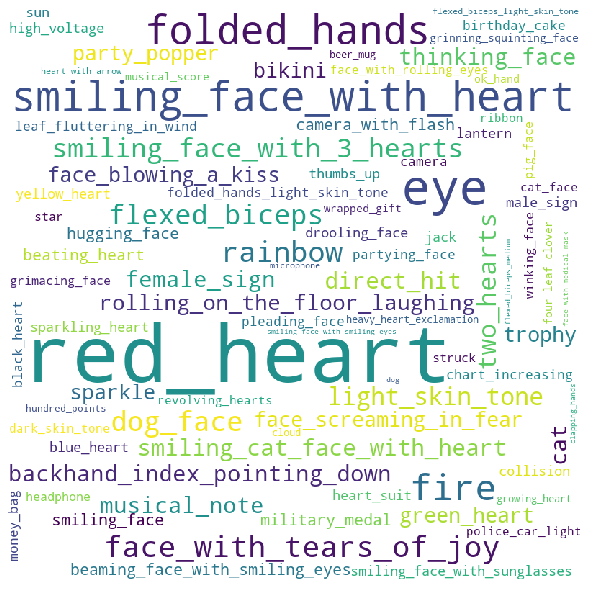

In [37]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_alt) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Here I make a word cloud for emojis in Low income users

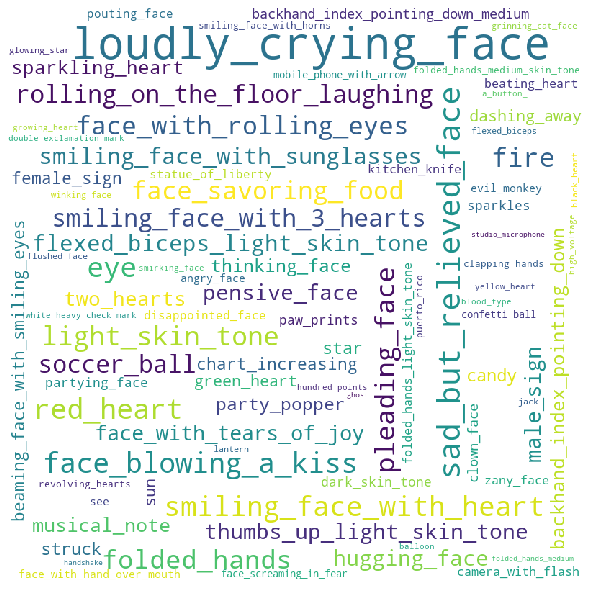

In [38]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_baj) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [39]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [40]:
def polaridad(sentence):
    if sentence=='':
        return np.nan
    return (0.5*sid.polarity_scores(sentence)['neu']+ sid.polarity_scores(sentence)['pos'])

Here I am proving the sentiment analysis of one emoji.

In [41]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
polaridad('face with rolling eyes')

0.5

# Creating new variables

In [42]:
def pintar_numeros(base_final,campo, order=None, rot=0):
    c=campo
    info=base_final.groupby(c).size()
    ax=base_final.groupby(c).size().plot(kind='bar', color='#c00000', align='center', width=0.8, alpha=0.7)
    plt.title('Clasificación por '+ c)
    plt.xlabel(c)
    plt.ylabel('Frecuencia')
    plt.ylim(0,max(info)+500)
    for i, v in enumerate(info):
        plt.text(i-0.1, v + 100, str(v))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.show()


First I graphed the label of income to discovered if the data is balanced or not. In this case I have balanced classes.

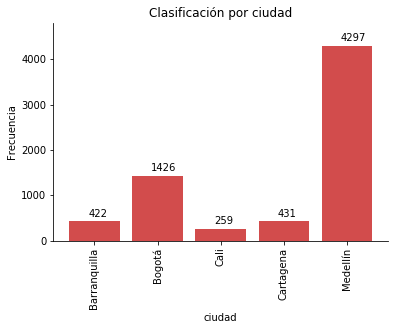

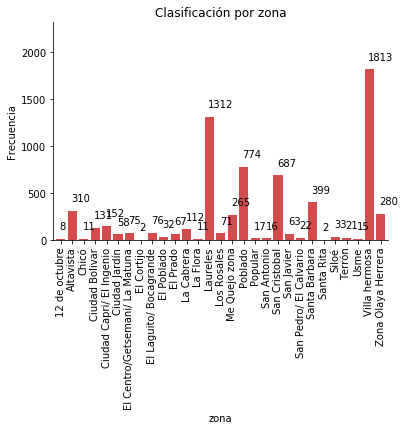

In [43]:
pintar_numeros(twitter_df, 'ingresos')
pintar_numeros(twitter_df, 'ciudad')
pintar_numeros(twitter_df, 'zona')

In this part of the code I decide toconvert the text of each tweet in a list of words, I follow the next steps:
    1. Eliminate all special characters like "html" cahracters.
    2. Eliminate the spanish stopwords.
    3. Split each sentence in words, and save the words in a list of words for each tweet.
    4. Stem each word with the spanish stemmer
    5. Save the list in a new variable

In [44]:
from bs4 import BeautifulSoup

def review_to_words(review):
    from nltk.corpus import stopwords
    stopwords2 =set(stopwords.words('spanish')+['colombia', 'bogotá', 'cartagena', 'medellín',
                                          'barranquilla', 'cali', 'antioquia', 'co', 'just', 'posted',
                                          'medellin','bogota', 'si', 'así', 'dio'])
    spanish_stemmer = SnowballStemmer('spanish')
    
    text = BeautifulSoup(review, "html.parser").get_text() # Remove HTML tags
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
               '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', text)
    text = re.sub("(#[A-Za-zá-úÁ-Ú0-9_]+)",'', text)
    text = re.sub("(@[A-Za-zá-úÁ-Ú0-9_]+)","", text)
    text = re.sub(r"[^a-zA-Zá-úÁ-Ú0-9]", " ", text.lower()) # Convert to lower case
    words = text.split() # Split string into words
    words = [w for w in words if w not in stopwords2] # Remove stopwords
    words = [spanish_stemmer.stem(word) for word in  words] # stem
    
    return words

In [45]:
review_to_words(twitter_df['Texto'].loc[15])

['anochec', 'santef', 'mall']

In [46]:
twitter_df['BOW']=twitter_df['Texto'].apply(review_to_words)

In [47]:
def get_sentiment(review):
    sentiment = sentiment_analysis.SentimentAnalysisSpanish()
    a= sentiment.sentiment(review)
    K.clear_session()
    #print(a)
    return a


In [ ]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
from keras import backend as K

Then I create the variable of spanish sentiment for each tweet in the data base

In [ ]:
resultado=[]
tot=0
for texto in list(twitter_df['Texto']):
    valor=get_sentiment(texto)
    
    tot+=1
    print(tot)
    resultado+=[valor]
    valorf=pd.DataFrame(resultado)
    valorf.to_csv('resulatdos.csv')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [48]:
valorf=pd.read_csv('resulatdos.csv')

In [49]:
twitter_df['spanish_sentiment']=valorf['0']

Then I created the emoji-sentiment and spelling variables

In [50]:
twitter_df['emoji_sentiment']=twitter_df['Texto_emojis'].apply(polaridad)

In [6]:
twitter_df['Ortografia']=twitter_df['Texto'].apply(iscorrect)

In [59]:
twitter_df

Texto    ciudad  \
0                        @solcaffarena3 😂😂😂 es verdad 🤣  Medellín   
1     Volar cual cohete, atacar como bólido. en Anti...  Medellín   
2     Liberación de sabaleta del compañero Carlos\n\...  Medellín   
3     Vamos empezando a dejarlo todo @industryclubme...  Medellín   
4     Pesca de sabaleta del compañero Carlos\n\n#esp...  Medellín   
...                                                 ...       ...   
6830                 @DaniClarkOfici1 Y a mi igual jaha  Medellín   
6831            Esta actualización de Twitter que ome 🤔  Medellín   
6832  Hoy entra en operación de la mina de oro de Bu...  Medellín   
6833  Sencillamente el rey del futbol https://t.co/z...  Medellín   
6834  Deja ir a personas que sólo llegan para compar...  Medellín   

           fecha_creacion  identificacion_tweet ingresos              usuario  \
0     2020-10-11 19:52:40   1315379811175497729    Altos  1269105923265564682   
1     2020-10-11 19:39:51   1315376588138205185    Altos   809919552020684800   
2     2020-10-11 17:49:19   1315348769387446272    Altos            801608203   
3     2020-10-11 17:45:58   1315347925598457862    Altos            304266436   
4     2020-10-11 17:38:26   1315346030104326144    Altos            801608203   
...                   ...                   ...      ...                  ...   
6830  2020-10-23 17:10:09   1319687570108854277    Bajos  1058126125220749312   
6831  2020-10-23 15:43:00   1319665636080078858    Bajos           1473335198   
6832  2020-10-23 15:24:05   1319660876614537216    Bajos  1050230947927523328   
6833  2020-10-23 15:03:59   1319655819064082433    Bajos            607811476   
6834  2020-10-23 13:55:03   1319638470210576385    Bajos            113086010   

           zona                                       Texto_emojis  \
0       Poblado  face with tears of joy face with tears of joy ...   
1       Poblado                                                      
2       Poblado                                                      
3       Poblado                                                      
4       Poblado                                                      
...         ...                                                ...   
6830  Altavista                                                      
6831  Altavista                                      thinking face   
6832  Altavista  white heavy check mark white heavy check mark ...   
6833  Altavista                                                      
6834  Altavista                                                      

                                                 emojis  spanish_sentiment  \
0      face_with_tears_of_joy  face_with_tears_of_jo...           0.504777   
1                                                                 0.504772   
2                                                                 0.504821   
3                                                                 0.232208   
4                                                                 0.504821   
...                                                 ...                ...   
6830                                                              0.507572   
6831                                     thinking_face            0.504160   
6832   white_heavy_check_mark  white_heavy_check_mar...           0.000000   
6833                                                              0.795300   
6834                                                              0.000000   

                                                    BOW  emoji_sentiment  \
0                                                [verd]            0.633   
1                               [vol, cohet, atac, bol]              NaN   
2                      [liber, sabalet, compañer, carl]              NaN   
3            [vam, empez, dej, ensegu, vem, burd, pobl]              NaN   
4                       [pesc, sabalet, compañer, carl]              NaN   
...           

# Visualization of new variables

First I decided to create a bar plot for sentiment analysis in spanish and emoji sentiment analysis, for each class to see if this variable can be significant in the models

In [62]:
with sns.axes_style(style='ticks'):
    g = sns.factorplot("ingresos", "spanish_sentiment", data=twitter_df, kind="box")
    #g.set(ylim=(0, 20))
    g.set_axis_labels("Sentimiento", "Ingresos")
    plp.title('Sentimiento vs Ingreso')

with sns.axes_style(style='ticks'):
    g = sns.factorplot("ingresos", "emoji_sentiment", data=twitter_df, kind="box")
    #g.set(ylim=(0, 20))
    g.set_axis_labels("Sentimiento", "Ingresos")
    plp.title('Sentimiento vs Ingreso')
  

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


In [20]:
from sklearn.metrics import confusion_matrix
twitter_df['ingresos2']=twitter_df['ingresos'].apply(lambda x: 0 if x=='Bajos' else 1)
ar=confusion_matrix(list(twitter_df['ingresos2']), list(twitter_df['Ortografia']))
pd.DataFrame(ar, index=['Low-Income', 'High -Income'], columns=['Bad Spelling', 'Good Spelling'])

Bad Spelling  Good Spelling
Low-Income            2829            838
High -Income          2958            210

It can be seen in this pont that this variables seems to be not significant, however is necessary to make more proves while running the models. 

# Train-Test Split

In this section I split the data in two. Train with 80% of data, and test of 20%. This split was made randomly.

In [60]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(twitter_df, test_size=0.2)

# Build Dictionary

In this part of the code I created a 5000 words disctionary based on the spanish words used in tweets. For this dictionary I assign a number to each frequent word, 0 when theres no word, and 1 when is an infrequent word.

This convention can be useful to make NLP with embedding methods.

In [63]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

def build_dict(data, vocab_size = 5000):
    """Construct and return a dictionary mapping each of the most frequently appearing words to a unique integer."""
    
    # TODO: Determine how often each word appears in `data`. Note that `data` is a list of sentences and that a
    #       sentence is a list of words.
    
    word_count = {} # A dict storing the words that appear in the reviews along with how often they occur
    lista=[item for sublist in data for item in sublist]
    word_count=dict(Counter(lista))
   
    
    # TODO: Sort the words found in `data` so that sorted_words[0] is the most frequently appearing word and
    #       sorted_words[-1] is the least frequently appearing word.
    
    sorted_words = sorted(word_count, key=word_count.get, reverse=True)
    
    word_dict = {} # This is what we are building, a dictionary that translates words into integers
    for idx, word in enumerate(sorted_words[:vocab_size - 2]): # The -2 is so that we save room for the 'no word'
        word_dict[word] = idx + 2                              # 'infrequent' labels
        
    return word_dict

In [76]:
word_dict=build_dict(train['BOW'])

In [70]:
def convert_and_pad(word_dict, list_sentence, pad=500):
    NOWORD = 0 # We will use 0 to represent the 'no word' category
    INFREQ = 1 # and we use 1 to represent the infrequent words, i.e., words not appearing in word_dict
    
    working_sentence = [NOWORD] * pad
    
    for word_index, word in enumerate(list_sentence[:pad]):
        if word in word_dict:
            working_sentence[word_index] = word_dict[word]
        else:
            working_sentence[word_index] = INFREQ
            
    return working_sentence, min(len(list_sentence), pad)

In [77]:
convert_and_pad(word_dict, train.BOW.iloc[0])

([632,
  3665,
  3666,
  16,
  508,
  633,
  3667,
  3668,
  3669,
  508,
  633,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

In [78]:
def convert_bow(sentence,word_dict, pad=500):
    converted, leng = convert_and_pad(word_dict, sentence, pad)
    return converted
def length_bow(sentence,word_dict, pad=500):
    converted, leng = convert_and_pad(word_dict, sentence, pad)
    return leng

In [80]:
train['bow_traducido']=train['BOW'].apply(convert_bow, args=(word_dict,))
train['bow_length']=train['BOW'].apply(length_bow, args=(word_dict,))

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [82]:
test['bow_traducido']=test['BOW'].apply(convert_bow, args=(word_dict,))
test['bow_length']=test['BOW'].apply(length_bow, args=(word_dict,))

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


Finally I saved the train and Data sets and the dictionary previously created.

In [84]:
train.to_csv('Data/Train.csv')
test.to_csv('Data/Test.csv')

In [88]:
import pickle
with open('Data/word_dict.pkl', 'wb') as handle:
    pickle.dump(word_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
1+1

2